# Trajectory Optimization and Vehicle Dynamics

Building a car simulator considering the tire model using Casadi and implement direct collocation for trajectory optimization.  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import casadi as ca
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import time

## Nonlinear MPC example

### Consider the dubin car model for motion generation

$$
\begin{equation}
\begin{aligned}
\dot{x} &= v \cos(\theta) \\
\dot{y} &= v \sin(\theta) \\
\dot{\theta} &= w \\
\dot{v} &= a \\
\end{aligned}
\end{equation}
$$

### Nonlinear MPC

$$
    \begin{aligned}
    J_0^{*}(x_{init}) = \min_{x_k, u_k} & \ p(x_N) + \sum_{k=0}^{N-1} q(x_k, u_k)\\ 
    \text{s.t. } 
                %  & x_{k+1} =  \ k = 0, \dots, N-1, \\
                & x_{k+1} = f(x_k, u_k), k = 0, \dots, N-1, \\
                & g(x_k, u_k) \le 0, \\
                & u_{\min} \le u_k \le u_{\max}, \\
                & x_0 = x_{init}. 
    \end{aligned}
$$

In [3]:
## define the constant in MPC
T = 4.
N = 40

h = T / N
Dim_ctrl =  2
Dim_state = 4

In [4]:
## define the dynamics
xm = ca.MX.sym("xm", (Dim_state, 1))
um = ca.MX.sym("um", (Dim_ctrl , 1))

xdot = ca.vertcat(
    xm[3] * ca.cos(xm[2]),
    xm[3] * ca.sin(xm[2]),
    um[0],
    um[1]
)

Fun_dynamics_dt = ca.Function('f_dt', [xm, um], [xdot * h + xm])

In [5]:
## define the upper bound of state and control inputs
state_ub = np.array([ 1e4,  1e4,  1e4,  1e4])
state_lb = np.array([-1e4, -1e4, -1e4, -1e4])
ctrl_ub  = np.array([ 1,  1])
ctrl_lb  = np.array([-1, -1])

# upper bound and lower bound
ub_x = np.matlib.repmat(state_ub, N + 1, 1)
lb_x = np.matlib.repmat(state_lb, N + 1, 1)

ub_u = np.matlib.repmat(ctrl_ub, N, 1)
lb_u = np.matlib.repmat(ctrl_lb, N, 1)

ub_var = np.concatenate((ub_u.reshape((Dim_ctrl * N, 1)), ub_x.reshape((Dim_state * (N+1), 1))))
lb_var = np.concatenate((lb_u.reshape((Dim_ctrl * N, 1)), lb_x.reshape((Dim_state * (N+1), 1))))

In [6]:
# Declare model variables
x = ca.MX.sym('x', (Dim_state, N + 1))
u = ca.MX.sym('u', (Dim_ctrl , N))
p = ca.MX.sym('p', (Dim_state, 1))

# dynamics constraints
cons_dynamics = []
ub_dynamics = np.zeros((N * Dim_state, 1))
lb_dynamics = np.zeros((N * Dim_state, 1))
for k in range(N):
    Fx = Fun_dynamics_dt(x[:, k], u[:, k])
    for j in range(Dim_state):
        cons_dynamics.append(x[j, k+1] -  Fx[j])

# state constraints: G(x) <= 0
alpha = 0.9
cons_state = []
for k in range(N):
    ## pure state constraints
    # cons_state.append( 9 - ((x[0, k] - 4)**2 + (x[1, k] - 4)**2) )
    # cons_state.append( 9 - ((x[0, k] - 4)**2 + (x[1, k] - 4)**2) )

    ## discrete time control barrier function
    Bk   = 9 - ((x[0, k] - 4)**2 + (x[1, k] - 4)**2)
    Bkp1 = 9 - ((x[0, k+1] - 4)**2 + (x[1, k+1] - 4)**2)
    cons_state.append( Bkp1 - alpha* Bk )
    

ub_state_cons = np.zeros((len(cons_state), 1))
lb_state_cons = np.zeros((len(cons_state), 1)) - 1e5

# cost function: 
J = 100 * ((x[0, -1] - 10)**2 + (x[1, -1] - 10)**2)  + 100 * x[2, -1]**2 + 100 * x[3, -1]**2
for k in range(N):
    J = J + 10 * ((x[0, k] - 10)**2 + (x[1, k] - 10)**2) + 10 * x[2, k]**2 + 10 * x[3, k]**2
    J = J + 1 * (u[0, k]**2 + u[1, k]**2)

# initial constraints
cons_init = [x[:, 0] - p]
lb_init_cons = np.zeros((Dim_state, 1))
ub_init_cons = np.zeros((Dim_state, 1))

vars_NLP   = ca.vertcat(u.reshape((Dim_ctrl * N, 1)), x.reshape((Dim_state * (N+1), 1)))
cons_NLP = cons_dynamics + cons_state + cons_init
cons_NLP = ca.vertcat(*cons_NLP)
lb_cons = np.concatenate((lb_dynamics, lb_state_cons, lb_init_cons))
ub_cons = np.concatenate((ub_dynamics, ub_state_cons, ub_init_cons))

n_x = vars_NLP.shape[0]
n_g = cons_NLP.shape[0]

# Create an NLP solver
prob = {"x": vars_NLP, "p":p, "f": J, "g":cons_NLP}
opts = {'ipopt.print_level': 0, 'print_time': 0} # , 'ipopt.sb': 'yes'}
solver = ca.nlpsol('solver', 'ipopt', prob , opts)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



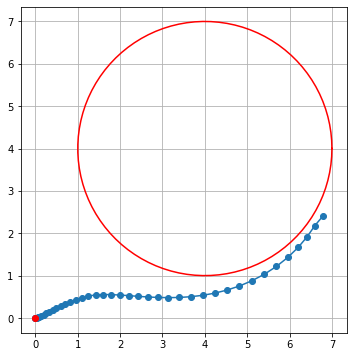

In [7]:
x0_nlp    = np.random.randn(n_x, 1) * 0
lamx0_nlp = np.random.randn(n_x, 1) * 0
lamg0_nlp = np.random.randn(n_g, 1) * 0

par_nlp = np.array([0, 0, 0, 0])# np.random.randn(Dim_state, 1)

sol = solver(x0=x0_nlp, lam_x0=lamx0_nlp, lam_g0=lamg0_nlp,
                     lbx=lb_var, ubx=ub_var, lbg=lb_cons, ubg=ub_cons, p = par_nlp)

x = sol["x"].full()[N*Dim_ctrl:]

plt.figure(figsize=(6, 6))
plt.plot(x[0::Dim_state], x[1::Dim_state], "-o")
plt.plot(x[0], x[1], "ro")
plt.plot(3 * np.cos(np.linspace(0, np.pi*2, 100)) + 4, 3 * np.sin(np.linspace(0, np.pi*2, 100)) + 4, "r")
plt.axis('scaled')
plt.grid("on")

In [8]:
N_sim = 400
x_log = np.zeros((N_sim + 1, Dim_state))
u_log = np.zeros((N_sim, Dim_ctrl))

x0_nlp    = np.zeros((n_x, 1))
lamx0_nlp = np.zeros((n_x, 1))
lamg0_nlp = np.zeros((n_g, 1))

x_log[0, :] = np.array([0, 0, 0, 0])

N_test = N_sim
for k in range(N_test):# range(N_sim):
    
    par_nlp = x_log[k, :]
    
    sol = solver(x0=x0_nlp, lam_x0=lamx0_nlp, lam_g0=lamg0_nlp,
                     lbx=lb_var, ubx=ub_var, lbg=lb_cons, ubg=ub_cons, p = par_nlp)

    x0_nlp = sol["x"].full()
    lamx0_nlp = sol["lam_x"].full()
    lamg0_nlp = sol["lam_g"].full()
    
    uk = sol["x"].full()[0:Dim_ctrl]
    xkp1 = Fun_dynamics_dt(x_log[k, :], uk)

    x_log[k + 1, :] = np.squeeze(xkp1)
    u_log[k, :]     = np.squeeze(uk)

x = sol["x"].full()[N*Dim_ctrl:]

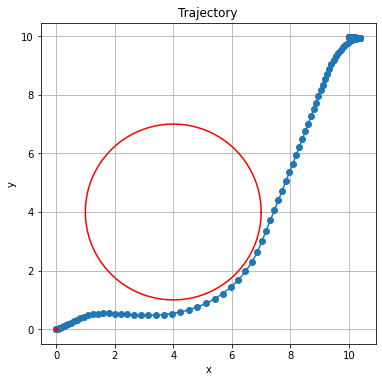

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(x_log[:, 0], x_log[:, 1], "-o")
plt.plot(x_log[0, 0], x_log[0, 1], "r.")
plt.plot(3 * np.cos(np.linspace(0, np.pi*2, 100)) + 4, 3 * np.sin(np.linspace(0, np.pi*2, 100)) + 4, "r")

plt.title("Trajectory")
plt.ylabel("y")
plt.xlabel("x")
plt.axis('scaled')
plt.grid("on")

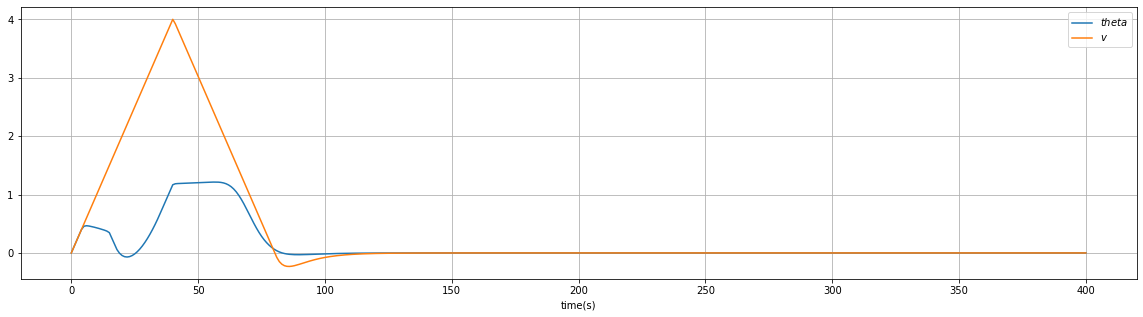

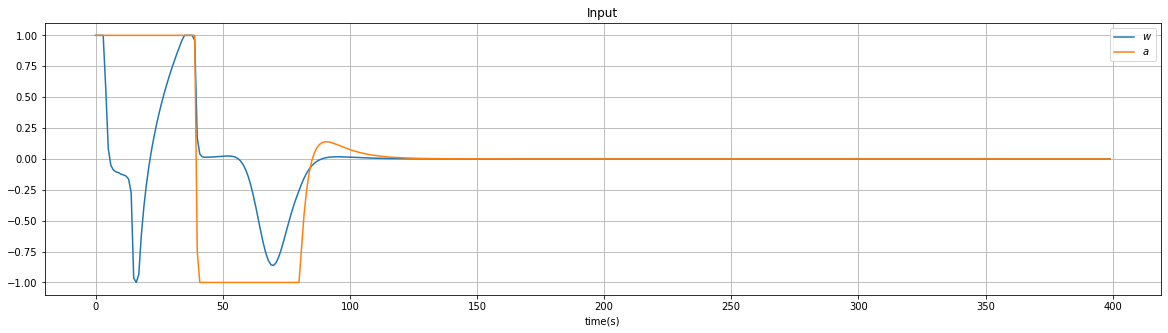

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(x_log[:, 2], label = "$theta$")
plt.plot(x_log[:, 3], label = "$v$")
plt.legend()
plt.grid("on")
plt.xlabel("time(s)")
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(u_log[:, 0], label = "$w$")
plt.plot(u_log[:, 1], label = "$a$")
plt.title("Input")
plt.legend()
plt.grid("on")
plt.xlabel("time(s)")
plt.show()

### Overview of Vehicle Dynamics

<div>
<img src="CarModel.png" width="1200">
</div>


\begin{aligned}
\dot{U}_x & =\frac{F_{x_f} \cos \delta-F_{y_f} \sin \delta+F_{x_r}-F_d}{m}+r U_y \\
\dot{U}_y & =\frac{F_{y_f} \cos \delta+F_{x_f} \sin \delta+F_{y_r}+F_b}{m}-r U_x \\
\dot{r} & =\frac{a\left(F_{y_f} \cos \delta+F_{x_f} \sin \delta\right)-b F_{y_r}}{I_{z z}} \\
\dot{s} & =\frac{U_x \cos \Delta \psi-U_y \sin \Delta \psi}{1-\kappa e} \\
\dot{e} & =U_x \sin \Delta \psi+U_y \cos \Delta \psi \\
\Delta \dot{\psi} & =r-\kappa \dot{s} \\

&\text{Consider parameter in the world frame:} \\
\dot{x} & = \cos(\phi)U_x - \sin(\phi)U_y  \\
\dot{y} & = \sin(\phi)U_x + \sin(\phi)U_y   \\ 
\dot{\phi} & =r  . \\
\end{aligned}

## Vehicle parameters

In [11]:
# param = { "m":1778., "Izz":3049.,"L_f":1.194, "L_r":1.436, "hcg":0.55, "Peng": 172. * 1000, "Frr": 218., "Cd": 0.4243,
#           "delta_max": 0.4712, "ddelta_max":0.3491, "C_alpha_f": 180. * 1000,"C_alpha_r": 300. * 1000,
#          "mu_f": 0.75,"mu_r": 0.8, "g":9.81, "mu_lim": 0.8} # from IEEE-TCST paper

param = { "m":1778., "Izz":3049.,"L_f":1.094-0.1, "L_r":1.536+0.1, "hcg":0.55, "Peng": 172. * 1000, "Frr": 218., "Cd": 0.4243,
          "delta_max": 0.4712, "ddelta_max":0.3491, "C_alpha_f": 180. * 1000,"C_alpha_r": 400. * 1000,
         "mu_f": 0.75,"mu_r": 0.6, "g":9.81, "mu_lim": 0.8}

## Traction Force Model

$$
F_{\chi_f} = \chi_f F_x
$$

$$
F_{\chi_r} = \chi_r F_x
$$

$$
\chi_f + \chi_r = 1
$$

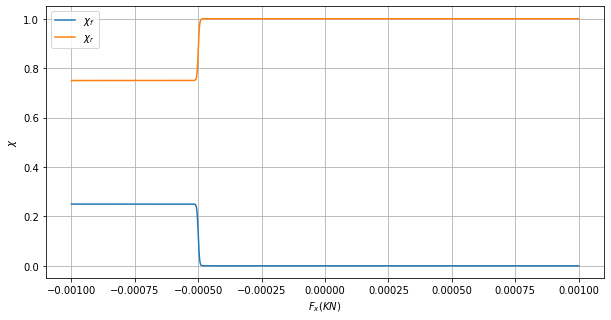

In [12]:
## distribution of traction force
def chi_fr(Fx):

    ## front-drive
    # xf = 0.125 * ca.tanh(2 * (Fx + 0.5)) + 0.875
    # xr = 1. - xf

    ## rear-drive
    xr = 0.125 * ca.tanh(2 * (Fx + 0.5) / 0.01) + 0.875
    xf = 1. - xr

    return xf * Fx, xr * Fx

Fx = np.linspace(-1, 1, 2000)
Fx_f, Fx_r = chi_fr(Fx)

plt.figure(figsize=(10, 5))
plt.plot(Fx / 1000, Fx_f / Fx, label = "$\chi_f$")
plt.plot(Fx / 1000, Fx_r / Fx, label = "$\chi_r$")
plt.xlabel("$F_x (KN)$")
plt.ylabel("$\chi$")

plt.legend()
plt.grid("on")

## Tire Model

### Slip angle

$$
\alpha_f = \arctan\left( \frac{U_y + L_fr}{U_x} \right) - \delta,
$$

$$
\alpha_r = \arctan\left( \frac{U_y - L_rr}{U_x} \right)
$$


### Friction cone limits

$$
F_y^{\max} = \sqrt{(\mu F_z)^2 - F_x^2},\ \ \ F_x \le \mu F_z.
$$

### Brush tire model

$$
\alpha_{sl} = \arctan\left( \frac{3\mu F_z}{C_{\alpha}} \right)
$$

$$
F_y= \begin{cases}-C_\alpha \tan \alpha+\frac{C_\alpha^2}{3 \mu F_z}|\tan \alpha| \tan \alpha-\frac{C_\alpha^3}{27 \mu^2 F_z^2} \tan ^3 \alpha & \text { if }|\alpha|<\alpha_{s l} \\ -\mu F_z \operatorname{sgn} \alpha & \text { otherwise }\end{cases}
$$

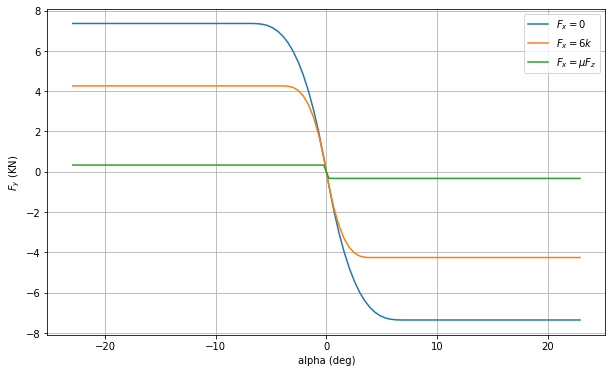

In [13]:
def get_slip_angle(Ux, Uy, r, delta, param):
    L_r = param["L_r"]
    L_f = param["L_f"]
    
    a_f = ca.arctan2((Uy + L_f * r), Ux) - delta
    a_r = ca.arctan2((Uy - L_r * r), Ux)
    return a_f, a_r

def tire_model_sim(alpha, Fz, Fx, C_alpha, mu):

    Fy_max_sq = (mu * Fz)**2 - (Fx)**2
    Fy_max = ca.if_else( Fy_max_sq <=0, 0, ca.sqrt(Fy_max_sq))
    
    alpha_slip = ca.arctan(3 * Fy_max / C_alpha)
    Fy = ca.if_else(ca.fabs(alpha) <= alpha_slip, 
        - C_alpha * ca.tan(alpha) 
        + C_alpha**2 * ca.fabs(ca.tan(alpha)) * ca.tan(alpha) / (3 * Fy_max)
        - C_alpha**3 * ca.tan(alpha)**3 / (27 * Fy_max**2), 
        - Fy_max * ca.sign(alpha))
    
    return Fy

def normal_load(Fx, param):
    # for both tires
    L_r = param["L_r"]
    L_f = param["L_f"]
    m = param["m"]
    g = param["g"]
    hcg = param["hcg"]
    
    L = (L_r + L_f)
    F_zf = L_r / L * m * g - hcg / L * Fx
    F_zr = L_f / L * m * g + hcg / L * Fx
    
    return F_zf, F_zr

Fx = 0.0
alpha = np.linspace(-0.4, 0.4, 100)

plt.figure(figsize=(10, 6))

Fy = tire_model_sim(alpha, 1000 * 9.81, 0, param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, label = "$F_x = 0$")

Fy = tire_model_sim(alpha, 1000 * 9.81, 6000, param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, label = "$F_x = 6k$")

Fy = tire_model_sim(alpha, 1000 * 9.81, 1000 * 9.8 * param["mu_f"], param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, label = "$F_x = \mu F_z$")

plt.ylabel("$F_y$ (KN)")
plt.xlabel("alpha (deg)")
plt.legend()
plt.grid("on")

## Path Indicator

we use parametric equation to generate the path. 

In [14]:
def GenPath(tau_num = np.linspace(0, 1, 20000)):
    # https://en.wikipedia.org/wiki/Curvature

    tau_num = np.reshape(tau_num, (1, -1)) ## time

    # r = R * ca.cos(tau * pr)
    # t = ca.cos(pt1 * tau) + ca.sin(pt2 * tau)
    
    tau = ca.MX.sym('tau', (1,1))
    
    # sin wave in y(x)
    R = 200
    x = tau * R * 2 # r * ca.sin(t)
    y = R * ca.sin(tau * 2 * np.pi * 2) + R * ca.sin(tau * np.pi**3) + R * ca.sin(tau * np.sqrt(13))# r * ca.cos(t)
    y = y / 5

    ## circle 
    # R = 50
    # x = R * ca.cos(tau * 2 * np.pi) - R
    # y = -R * ca.sin(tau * 2 * np.pi)# r * ca.cos(t)

    ## star
    # R = 50 + 20 * np.sin(tau * 50 * np.pi)
    # x = R * ca.cos(tau * 2 * np.pi)
    # y = -R * ca.sin(tau * 2 * np.pi)# r * ca.cos(t)

    # ## mountain
    # R =  200
    # x =  R * tau
    # y = -R * ca.sin(tau * 2 * np.pi * 2) + R * tau * 2 # r * ca.cos(t)
    
    dx = ca.jacobian(x, tau)
    dy = ca.jacobian(y, tau)
    
    d2x = ca.jacobian(dx, tau)
    d2y = ca.jacobian(dy, tau)
    
    # kappa = ca.fabs(dx * d2y - dy * d2x) * (dx**2 + dy**2 + 1e-10)**(-1.5)
    kappa = (dx * d2y - dy * d2x) * (dx**2 + dy**2 + 1e-10)**(-1.5)
    psi   = ca.atan2(dy, dx)
    
    ds = ca.sqrt(dx**2 + dy**2)
    
    xm = ca.MX.sym('xm', (1, 1))
    dae={'x':xm, 't':tau, 'ode':ds}

    integrator = ca.integrator('integrator', 'cvodes', dae, {'grid':np.squeeze(tau_num), 'output_t0':True})
    
    fun = ca.Function("fun", [tau], [ca.vertcat(x, y, psi, kappa)])
    sol = integrator(x0=[0])
    s = np.array(sol["xf"]).T
    p = np.array(fun(tau_num))
    
    path_data = {"s": np.squeeze(s), "x": np.squeeze(p[0, :]), "y": np.squeeze(p[1, :]), "psi": np.squeeze(p[2, :]), "kappa": np.squeeze(p[3, :]) }
    
    path_px_table    = ca.interpolant("LUT", "bspline", [np.squeeze(s)], p[0, :])
    path_py_table    = ca.interpolant("LUT", "bspline", [np.squeeze(s)], p[1, :])
    path_yaw_table   = ca.interpolant("LUT", "bspline", [np.squeeze(s)], p[2, :])
    path_kappa_table = ca.interpolant("LUT", "bspline", [np.squeeze(s)], p[3, :])
    
    return path_data, path_px_table, path_py_table, path_yaw_table, path_kappa_table

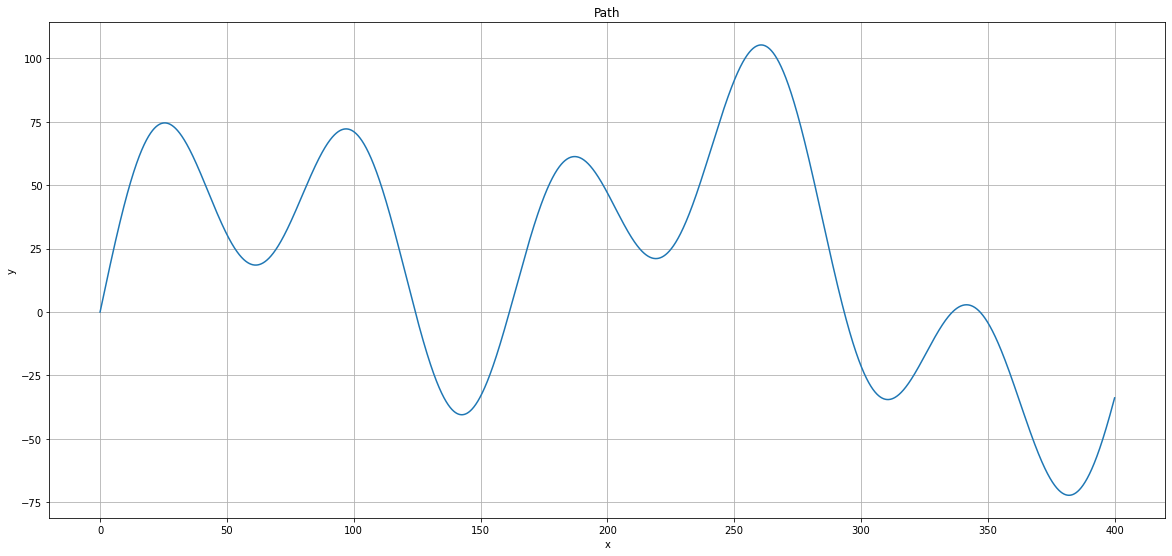

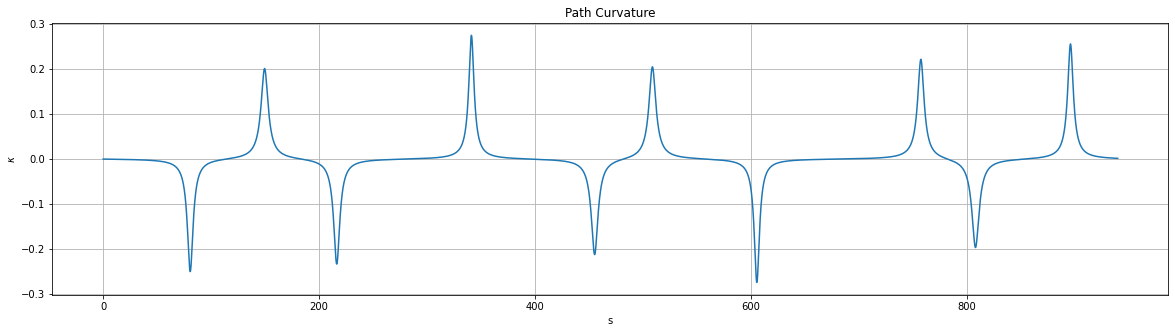

In [15]:
path_data, path_px_table, path_py_table, path_yaw_table, path_kappa_table = GenPath()

plt.figure(figsize=(20, 10))
plt.plot(path_data["x"], path_data["y"])
plt.title("Path")
plt.axis('scaled')
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()


plt.figure(figsize=(20, 5))
plt.plot(path_data["s"], path_kappa_table(path_data["s"]))
plt.title("Path Curvature")
plt.xlabel("s")
plt.ylabel("$\kappa$")
# plt.xlim([0, 200])
plt.grid()
plt.show()

## Car simulator

In [16]:
def GetCarModel(kappa_table, ts = np.linspace(0, 0.025, 10), ode = "cvodes"):
    # system dimensions
    Dim_state = 6 + 3 ## Ux Uy r | s r dpsi
    Dim_ctrl  = 2 ## Fx delta

    # Continuous time dynamics model
    xm = ca.MX.sym('xm', (Dim_state, 1))
    um = ca.MX.sym('um', (Dim_ctrl, 1))

    ##
    Fx = um[0]
    delta = um[1]

    Fxf, Fxr = chi_fr(Fx)

    ## resistance, need to deal with the discontinuity at 0
    Fd = param["Frr"] + param["Cd"] * xm[0]**2
    # Fd = Fd * ca.if_else(xm[0] >= 0, -1, 1)
    Fd = Fd * ca.tanh(- xm[0] * 10000)
    Fb = 0.0
    ## 
    
    af, ar = get_slip_angle(xm[0], xm[1], xm[2], delta, param)
    Fzf, Fzr = normal_load(Fx, param)
    Fxf, Fxr = chi_fr(Fx)

    ##
    Fxf = ca.if_else( ca.fabs(Fxf) >= param["mu_f"] * ca.fabs(Fzf), 
                     param["mu_f"] * ca.fabs(Fzf) * ca.sign(Fxf) ,
                       Fxf)
    
    Fxr = ca.if_else( ca.fabs(Fxr) >= param["mu_r"] * ca.fabs(Fzr), 
                     param["mu_r"] * ca.fabs(Fzr) * ca.sign(Fxr) ,
                       Fxr)
    
    Fyf = tire_model_sim(af, Fzf, Fxf, param["C_alpha_f"], param["mu_f"])
    Fyr = tire_model_sim(ar, Fzr, Fxr, param["C_alpha_r"], param["mu_r"])

    dUx  = (Fxf * ca.cos(delta) - Fyf * ca.sin(delta) + Fxr + Fd) / param["m"] + xm[2] * xm[1]
    dUy  = (Fyf * ca.cos(delta) + Fxf * ca.sin(delta) + Fyr + Fb) / param["m"] - xm[2] * xm[0]
    dr   = (param["L_f"] * (Fyf * ca.cos(delta) + Fxf * ca.sin(delta)) - param["L_r"] * Fyr) / param["Izz"] 
    
    ds   = (xm[0] * ca.cos(xm[5]) - xm[1] * ca.sin(xm[5])) / (1.0 - kappa_table(xm[3]) * xm[4])
    de   = xm[0] * ca.sin(xm[5]) + xm[1] * ca.cos(xm[5])
    dpsi = xm[2] - kappa_table(xm[3]) * ds

    dx   = ca.cos(xm[5 + 3]) * xm[0] - ca.sin(xm[5 + 3]) * xm[1]
    dy   = ca.sin(xm[5 + 3]) * xm[0] + ca.cos(xm[5 + 3]) * xm[1]
    dyaw = xm[2]
      
    xdot = ca.vertcat(dUx, dUy, dr, 
                       ds,  de, dpsi,
                       dx,  dy, dyaw)
    
    fx = ca.vertcat(Fxf, Fyf, Fzf, af, Fxr, Fyr, Fzr, ar, xdot)
    Fun_dynmaics_ct = ca.Function('f_ct', [xm, um], [fx])

    t = ca.MX.sym('t', (1, 1))

    #! We will simulate over 50 seconds, 1000 timesteps.
    dae={'x':xm, 'p':um, 't':t, 'ode':xdot}
    integrator = ca.integrator('integrator', ode, dae, {'grid':ts, 'output_t0':True})

    return integrator, Fun_dynmaics_ct


def SimVehicle(y0, controller, integrator, car_dynamics, N_sim):
    ## y0: initial condition
    tire_force_log = np.zeros((17, 1))
    x_log = np.array(y0)
    u_log = np.array([[0, 0]]).T
    u = np.array([[300., 0]]).T

    start = time.time()
    for k in range(N_sim):
        uk_last = u + 0.0
        u = controller(y0, uk_last, k)
        
        ## we consider some dynamics of the car transmission system
        alpha = 0.05
        u = u * alpha + uk_last * (1 - alpha)

        ## Saturation of control efforts
        Fx_max = np.abs(param['Peng'] / (np.abs(y0[0]) + 0.001))

        u[0] =  np.clip(u[0], -Fx_max, Fx_max)  
        u[1] =  np.clip(u[1], -param['delta_max'], param['delta_max'])      
        ## 
        
        sol = integrator(x0 = y0, p = u)
        y0 = sol["xf"][:, -1]

        # print(y0)
        # x_log = np.concatenate((x_log, sol["xf"][:, -1]), axis = 1)
        x_log = np.concatenate((x_log, sol["xf"][:, 1:]), axis = 1)
        # x_log = np.concatenate((x_log, y0), axis = 1)
        u_log = np.concatenate((u_log, u), axis = 1)

        dx = car_dynamics(y0, u)
        tire_force_log = np.concatenate((tire_force_log, np.reshape(dx, (17, 1) )), axis = 1)

    end = time.time()
    print("Simulation completed. Spend %f secs"% (end - start))

    return x_log, u_log, tire_force_log


In [17]:
T_sim  = 40
dt_ctrl = 0.025 / 2
N_sim = int(np.ceil(T_sim / dt_ctrl))
integrator, car_dynamics = GetCarModel(path_kappa_table, ts = np.linspace(0, dt_ctrl, 2), ode = "rk")
sim_time = np.linspace(0, T_sim, N_sim + 1)
N_sim

3200

In [18]:
def PD_controller(y0, uk_last, k, param):
    kp = np.pi / 180 * 2
    xLA = 40
    L = (param["L_f"] + param["L_r"])

    FzF = param["m"] * param["L_r"] * param["g"] / L
    FzR = param["m"] * param["L_f"] * param["g"] / L
    Kug = (FzF / param["C_alpha_r"] - FzR / param["C_alpha_r"]) / param["g"]

    Kappa = path_kappa_table(y0[0])
    # betaSS = (param["L_r"] - ((param["L_f"] * param["m"] * (y0[0] ** 2)) / (param["C_alpha_f"] * L ))) * Kappa # steady-state sideslip

    _, alpha_r = get_slip_angle(y0[0], y0[1], Kappa * y0[0], uk_last[1], param)

    betaSS = param["L_r"] * Kappa + alpha_r # steady-state sideslip

    deltaFB = -kp * (y0[4] * 2 + xLA * (y0[5] + betaSS)) # look-ahead error
    deltaFFW = L * Kappa + Kug * (y0[0] ** 2) * Kappa

    delta = deltaFB + deltaFFW
    Fx    = 75 * (25 - y0[0]) + param["Frr"] + param["Cd"] * y0[0]**2#  - 100 * np.abs(y0[4])

    u = np.array([[0., 0]]).T
    u[1, 0] = np.clip(delta, -param["delta_max"], param["delta_max"])
    u[0, 0] = Fx

    return u

def saturation_controller(y0, uk_last, k, param):
    
    u = np.array([[0., 0]]).T

    if np.mod(k, 4000) < 2000:
        u[0, 0] = 50 * (5 - y0[0]) + param["Frr"] + param["Cd"] * y0[0]**2
    else:
        u[0, 0] = 60 * (0 - y0[0]) + param["Frr"] + param["Cd"] * y0[0]**2

    if np.mod(k, 3000) < 1000:
        u[1, 0] = -0.4
    else:
        u[1, 0] = +0.4

    u[1, 0] = np.clip(u[1, 0], -param["delta_max"], param["delta_max"])

    return u

def high_speed_turning_controller(y0, uk_last, k, param):
    
    u = np.array([[0., 0]]).T

    if k < 2000:
        u[0, 0] = 2000 + param["Cd"] * y0[0]**2 # 100 * (30 - y0[0]) + param["Frr"] + param["Cd"] * y0[0]**2
        u[1, 0] = 0.0
    else:
        # u[0, 0] = -800 # 30 * (0 - y0[0]) # + param["Frr"] + param["Cd"] * y0[0]**2
        # u[0, 0] = 1000 + param["Cd"] * y0[0]**2 # 30 * (0 - y0[0]) # + param["Frr"] + param["Cd"] * y0[0]**2
        u[0, 0] = 300 * (0 - y0[0]) + param["Cd"] * y0[0]**2
        u[1, 0] = 0.35

    u[1, 0] = np.clip(u[1, 0], -param["delta_max"], param["delta_max"])

    return u

In [19]:
controller_exec = lambda y, uk_last, k: saturation_controller(y, uk_last, k, param); epsi_init = -path_data["psi"][0]
controller_exec = lambda y, uk_last, k: high_speed_turning_controller(y, uk_last, k, param); epsi_init = -path_data["psi"][0]
controller_exec = lambda y, uk_last, k: PD_controller(y, uk_last, k, param); epsi_init = 0.2

In [20]:
s_init = path_data["s"][0]
ey_init = 5.0
# epsi_init = -path_data["psi"][0]

phi_init = path_data["psi"][0] + epsi_init
xw_init = -np.sin(phi_init) * ey_init + path_data["x"][0]
yw_init =  np.cos(phi_init) * ey_init + path_data["y"][0]

y0 = np.array([[2, 0, 0, 
                s_init, ey_init, epsi_init,
                xw_init, yw_init, phi_init]]).T

x_log, u_log, tire_force_log = SimVehicle(y0, controller_exec, integrator, car_dynamics, N_sim)

Simulation completed. Spend 2.328956 secs


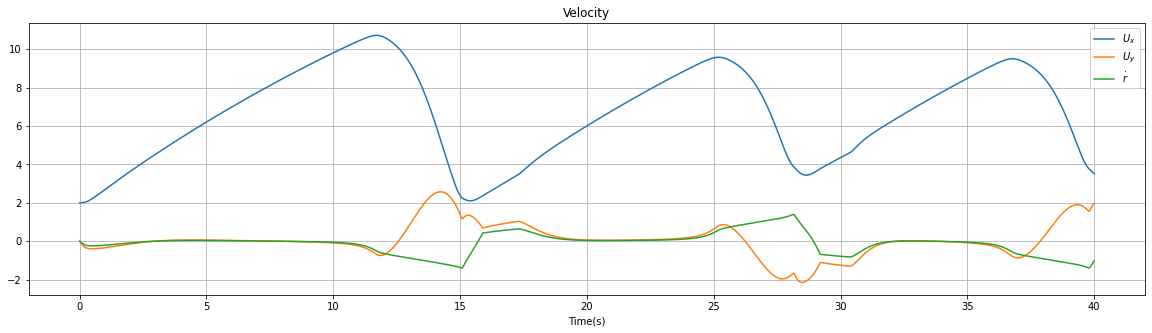

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(sim_time, x_log[0, :], label = "$U_x$" )
plt.plot(sim_time, x_log[1, :], label = "$U_y$" )
plt.plot(sim_time, x_log[2, :], label = "$\dot{r}$" )

plt.title("Velocity")
plt.xlabel("Time(s)")
plt.legend()
plt.grid()
plt.show()

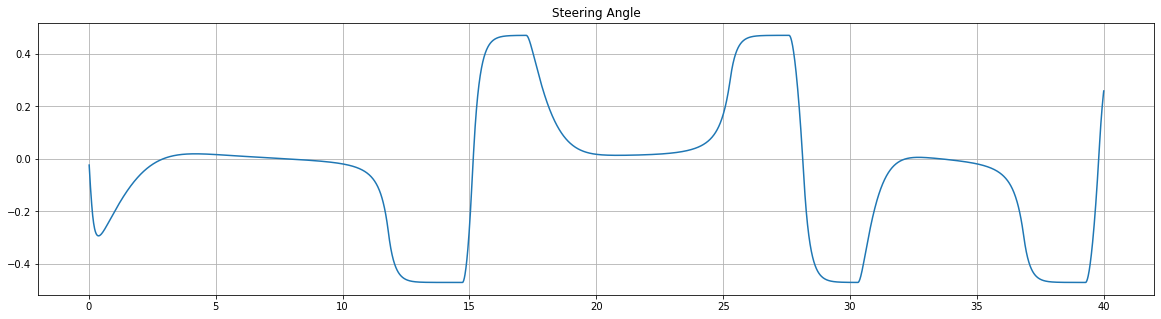

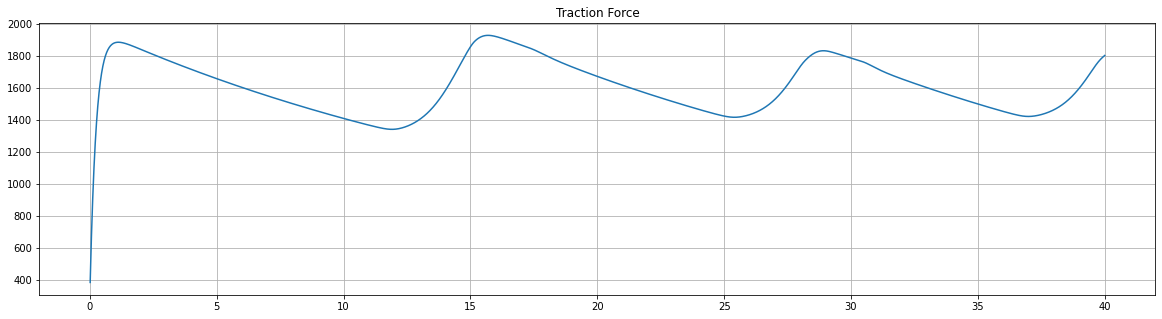

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(sim_time[1:], u_log[1, 1:])
plt.title("Steering Angle")
plt.grid()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(sim_time[1:], u_log[0, 1:])
plt.title("Traction Force")
plt.grid()
plt.show()

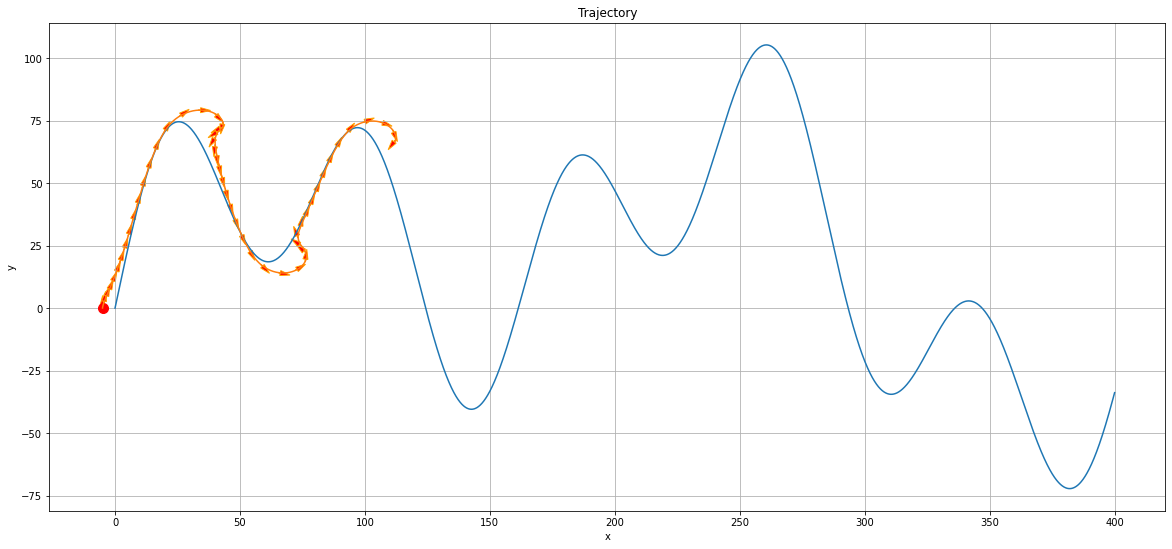

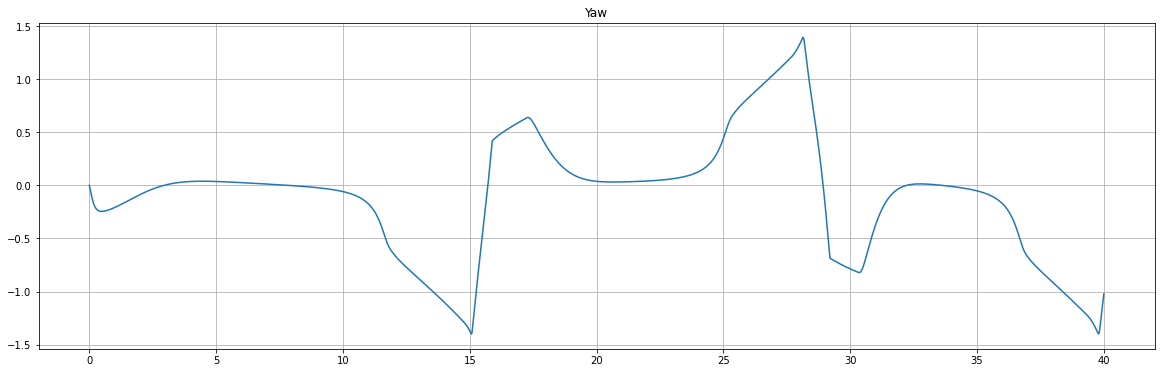

In [23]:
# yaw_path  = path_yaw_table(x_log[3, :])
# yaw_world = yaw_path + x_log[5, :]

## if consider feedback in the path coordinate
# x_w_path = -np.sin(yaw_path) * x_log[4, :] + path_px_table(x_log[3, :])
# y_w_path =  np.cos(yaw_path) * x_log[4, :] + path_py_table(x_log[3, :])


# trajectory in the world frame
x_w = x_log[-3, :]
y_w = x_log[-2, :]

x0 = np.expand_dims(x_w, 1)
y0 = np.expand_dims(y_w, 1)
yaw = x_log[-1, :]
dx, dy = np.expand_dims(np.cos(yaw), 1), np.expand_dims(np.sin(yaw), 1)
arrows = np.concatenate((x0, y0, dx, dy), axis=1)[0::65, :]

plt.figure(figsize=(20, 10))
plt.plot(path_data["x"], path_data["y"])
plt.plot(x_w[0], y_w[0], "r.", markersize = 20)

for arrow in arrows:
    plt.arrow(arrow[0], arrow[1], arrow[2], arrow[3], head_width=2, head_length=4, fc='red', ec='orange')

# plt.plot(x_w_path, y_w_path)
plt.plot(x_w, y_w)
plt.axis("scaled")

plt.title("Trajectory")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(sim_time, x_log[2, :], label = "Yaw")
plt.title("Yaw")
plt.grid()
plt.show()

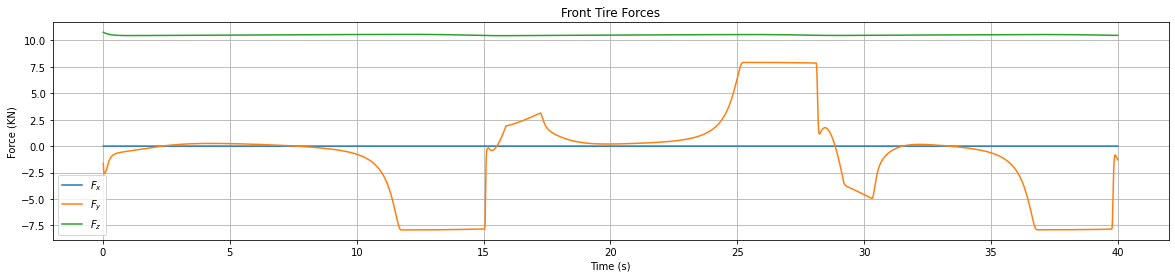

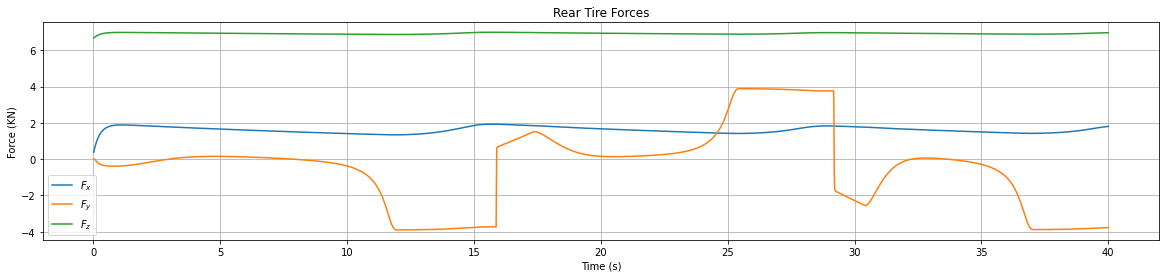

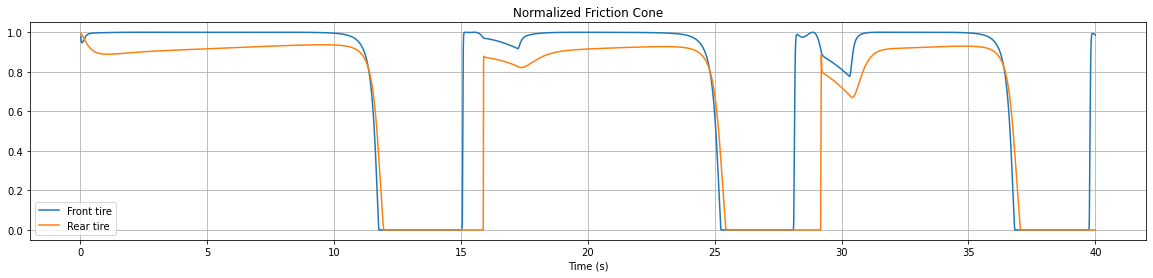

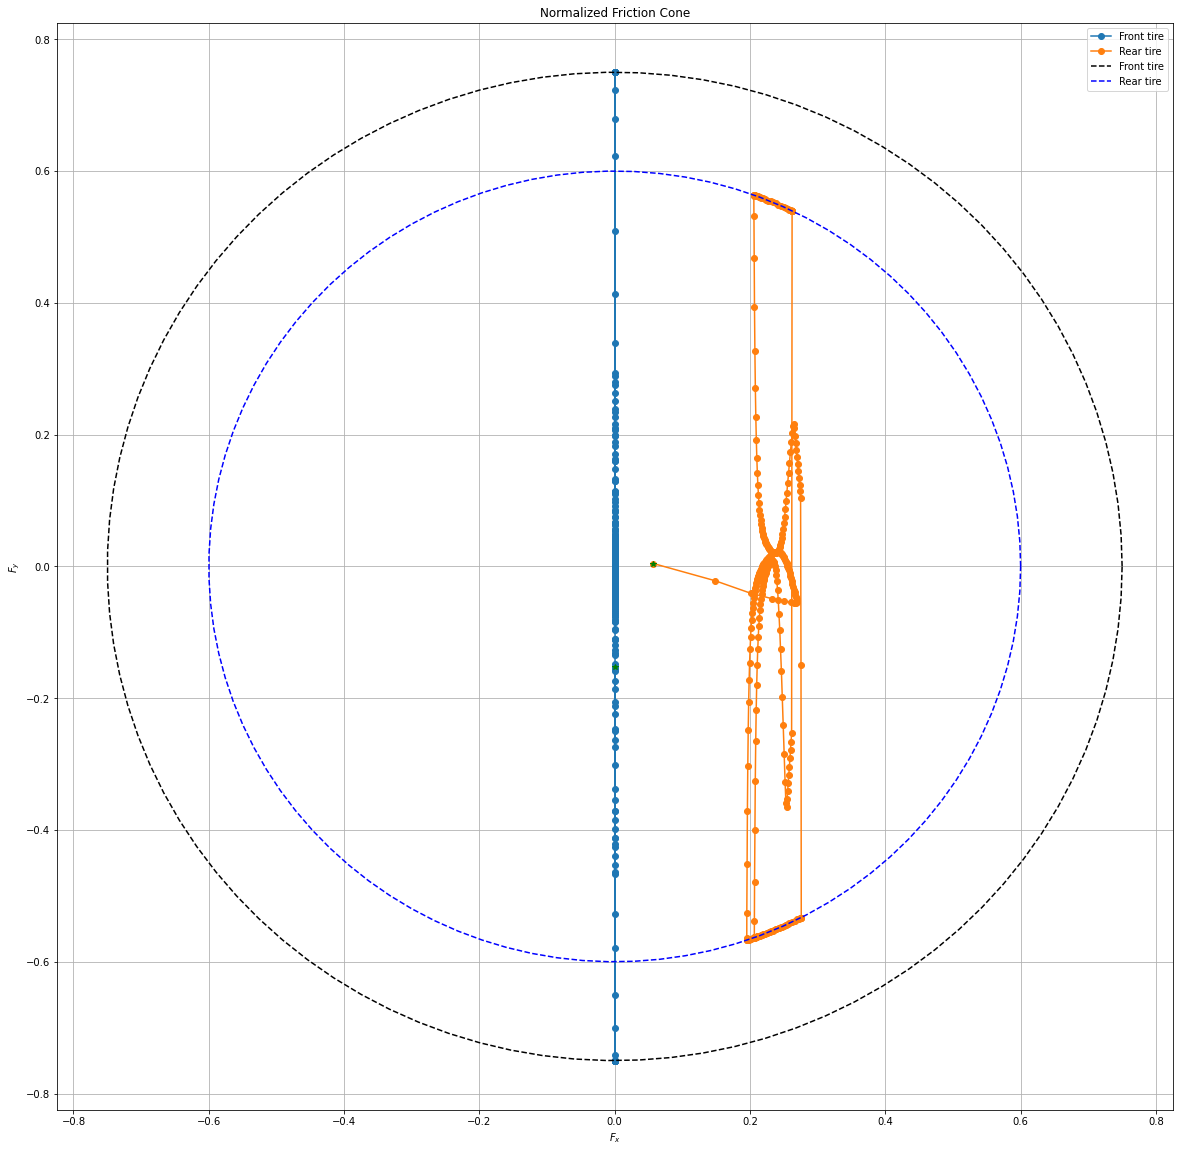

In [24]:
plt.figure(figsize=(20, 4))
plt.plot(sim_time[1:], tire_force_log[0:3, 1:].T / 1000)
plt.title("Front Tire Forces")
plt.legend(["$F_x$", "$F_y$", "$F_z$"])
plt.ylabel("Force (KN)")
plt.xlabel("Time (s)")
plt.grid()
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(sim_time[1:], tire_force_log[4:7, 1:].T / 1000)
plt.title("Rear Tire Forces")
plt.legend(["$F_x$", "$F_y$", "$F_z$"])
plt.ylabel("Force (KN)")
plt.xlabel("Time (s)")
plt.grid()
plt.show()

cone_1 = np.sqrt( param["mu_f"]**2 * tire_force_log[2, 1:].T **2 - tire_force_log[0, 1:].T **2 - tire_force_log[1, 1:].T **2 + 1e-2) / (param["mu_f"] * tire_force_log[2, 1:].T)
cone_2 = np.sqrt( param["mu_r"]**2 * tire_force_log[6, 1:].T **2 - tire_force_log[4, 1:].T **2 - tire_force_log[5, 1:].T **2 + 1e-2) / (param["mu_r"] * tire_force_log[6, 1:].T)

plt.figure(figsize=(20, 4))
plt.plot(sim_time[1:], cone_1 , label = "Front tire" )
plt.plot(sim_time[1:], cone_2 , label = "Rear tire" )
plt.title("Normalized Friction Cone")
plt.xlabel("Time (s)")
plt.legend()
plt.grid()
plt.show()


inter = 10
Fx_f = tire_force_log[0, 1::inter].T / tire_force_log[2, 1::inter].T
Fy_f = tire_force_log[1, 1::inter].T / tire_force_log[2, 1::inter].T

Fx_r = tire_force_log[4, 1::inter].T / tire_force_log[6, 1::inter].T
Fy_r = tire_force_log[5, 1::inter].T / tire_force_log[6, 1::inter].T


plt.figure(figsize=(20, 20))
plt.plot(Fx_f, Fy_f , "-o",  label = "Front tire" )
plt.plot(Fx_r, Fy_r , "-o", label = "Rear tire" )

plt.plot(Fx_f[0], Fy_f[0] , "g*")
plt.plot(Fx_r[0], Fy_r[0] , "g*")

plt.plot(np.cos(np.linspace(0, np.pi * 2, 100)) * param["mu_f"], np.sin(np.linspace(0, np.pi * 2, 100)) * param["mu_f"], "k--", label = "Front tire")
plt.plot(np.cos(np.linspace(0, np.pi * 2, 100)) * param["mu_r"], np.sin(np.linspace(0, np.pi * 2, 100)) * param["mu_r"], "b--", label = "Rear tire")

plt.title("Normalized Friction Cone")
plt.ylabel("$F_y$")
plt.xlabel("$F_x$")
plt.legend()
plt.grid()
plt.show()